# Deck 195 ID Experiment

K.Wood

The ICOADS material you provided for Typhoon Cobra did yield an ID prefix for DEs (Destroyer Escorts) = 14nnn and the cruisers (CA and CL) = 02nnn and 06nnn. I think aircraft carriers (CV and CVE) = 07nnn and 10nnn. Battleships are certainly 01nnn. 

The DCK 195 punch card metadata show potential prefixes are 01-99 (pp-pp), and hull numbers 001-999 (nnn-nnn). 

Now we know the combatant ships are in the small numbers, probably in some kind of grouping, as battleships and cruisers -- aircraft carriers -- destroyers and destroyer escorts, followed by auxiliaries. These latter are mostly "A" designated ships - AK (cargo), AO (fleet oiler) for example, and I suspect the ID numbers are on high end -- say 50-99.  

Would it be possible to extract a) the set of unique prefixes and b) unique prefixes + hull numbers into a table, perhaps with a count of obs associated with the ID and the dates of first and last occurrence? That would be   

a) pp(1-n) 
b) ppnnn, count, date(1), date (n)

I think that would reveal whether there are blocks of IDs associated with different large classes, and the fleet composition in the dataset. On the latter, probably heavy on DDs and DEs. Separately, I have the lists of commissioned ships by type from the Navy -- that's the BB and DD letters, and from that we can understand how complete the punch card project was. 



In [94]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from requests.exceptions import HTTPError


In [36]:
server_url = 'http://akutan.pmel.noaa.gov:8080/erddap'

In [37]:
e = ERDDAP(server=server_url)
# searchterm mooring... subset this later
df = pd.read_csv(e.get_search_url(response='csv', search_for='ICOADS'))

In [38]:
print(df['Dataset ID'].values)

['datasets_IMMA_ICOADS_ncei_1600s' 'datasets_IMMA_ICOADS_ncei_1700s'
 'datasets_IMMA_ICOADS_ncei_1800s' 'datasets_IMMA_ICOADS_ncei_1900s'
 'datasets_IMMA_ICOADS_ncei_1910s' 'datasets_IMMA_ICOADS_ncei_1920s'
 'datasets_IMMA_ICOADS_ncei_1930s' 'datasets_IMMA_ICOADS_ncei_1940s'
 'datasets_IMMA_ICOADS_ncei_1950s' 'datasets_IMMA_ICOADS_ncei_1960s'
 'datasets_IMMA_ICOADS_ncei_1970s' 'datasets_IMMA_ICOADS_ncei_1980s'
 'datasets_IMMA_ICOADS_ncei_1990s' 'datasets_IMMA_ICOADS_ncei_2000s'
 'datasets_IMMA_ICOADS_ncei_2010s']


In [39]:
kw = {
}

constraints = {
    'DCK=': "195",
}


In [40]:
temp_data = ['datasets_IMMA_ICOADS_ncei_1940s']

In [394]:
for dataset_id in temp_data:
        #read and import dataset
        print(dataset_id)
        try:
            d = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            d.constraints=constraints
            d.dataset_id=dataset_id
        except HTTPError:
            print('Failed to generate url {}'.format(dataset_id))

        try:
            df_m = d.to_pandas(
                        #index_col='time (UTC)',
                        parse_dates=True,
                        skiprows=(1,)  # units information can be dropped.
                        )
            df_m.sort_index(inplace=True)
            df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
            df_m['ID'] = df_m['ID'].astype(str)

        except:
            print(f"something failed in data download {dataset_id}")
            pass

datasets_IMMA_ICOADS_ncei_1940s


/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## ID Cleanup and potential assumptions

- initially : 598013 records (few thousand less than previous reports suggest)

- strip all decimal options
- pad all id's to be 5 characters long

- sort by prefix (total dropped measurements =
    + prefix '-1' -> could be '01' given keyboard proximity.  This would make all ('-1292', '-1318')  Battleship class? if so, they are not subsets of ships that have correct data - would need to verify against hull number (REMOVE from RECORD - 557)
    + prefix '0 ', '1 ','9 ' -> not sure what the coding mistake could be ('0 010', '1 129', '1 242', '9  11') (REMOVE from RECORD - 4)
    + prefix 'J1', 'T4', 'ZV' -> coding mistakes for ??? ('J1015', 'T4257', 'ZV003')  (REMOVE from RECORD - 56)
    + suffix = nan (no ID) (REMOVE from RECORD - 929)
    + suffix '0 0', '0 1', '2 1', '20-' (REMOVE from RECORD - 89)

In [402]:
#clean ids of decimals and other integer artifacts
df_m['ID_clean']=''
#add unique prefixes and 3dig suffixes
df_m['ID_pre']=''
df_m['ID_suf']=''
for index, row in df_m.iterrows():
    df_m.at[index, 'ID_clean']=row['ID'].split('.')[0].strip().zfill(5)
    df_m.at[index, 'ID_pre']=row['ID'].split('.')[0].strip().zfill(5)[0:2]
    df_m.at[index, 'ID_suf']=row['ID'].split('.')[0].strip().zfill(5)[2:]
    

In [414]:
indexNames = df_m[ df_m['ID_pre'] == '-1' ].index
print(f'dropping {len(indexNames)} \'-1\'')
df_m.drop(indexNames , inplace=True)
indexNames = df_m[ df_m['ID_pre'] == '0 ' ].index
print(f'dropping {len(indexNames)} \'0 \'')
df_m.drop(indexNames , inplace=True)
indexNames = df_m[ df_m['ID_pre'] == '1 ' ].index
print(f'dropping {len(indexNames)} \'1 \'')
df_m.drop(indexNames , inplace=True)
indexNames = df_m[ df_m['ID_pre'] == '9 ' ].index
print(f'dropping {len(indexNames)} \'9 \'')
df_m.drop(indexNames , inplace=True)
indexNames = df_m[ df_m['ID_pre'] == 'J1' ].index
print(f'dropping {len(indexNames)} \'J1\'')
df_m.drop(indexNames , inplace=True)
indexNames = df_m[ df_m['ID_pre'] == 'T4' ].index
print(f'dropping {len(indexNames)} \'T4\'')
df_m.drop(indexNames , inplace=True)
indexNames = df_m[ df_m['ID_pre'] == 'ZV' ].index
print(f'dropping {len(indexNames)} \'ZV\'')
df_m.drop(indexNames , inplace=True)

indexNames = df_m[ df_m['ID_suf'] == 'nan' ].index
print(f'dropping {len(indexNames)} \'nan\'')
df_m.drop(indexNames , inplace=True)

indexNames = df_m[ df_m['ID_suf'] == '0 0' ].index
print(f'dropping {len(indexNames)} \'0 0\'')
df_m.drop(indexNames , inplace=True)
indexNames = df_m[ df_m['ID_suf'] == '0 1' ].index
print(f'dropping {len(indexNames)} \'0 1\'')
df_m.drop(indexNames , inplace=True)
indexNames = df_m[ df_m['ID_suf'] == '2 1' ].index
print(f'dropping {len(indexNames)} \'2 1\'')
df_m.drop(indexNames , inplace=True)
indexNames = df_m[ df_m['ID_suf'] == '20-' ].index
print(f'dropping {len(indexNames)} \'20-\'')
df_m.drop(indexNames , inplace=True)

dropping 0 '-1'
dropping 0 '0 '
dropping 0 '1 '
dropping 0 '9 '
dropping 0 'J1'
dropping 0 'T4'
dropping 0 'ZV'
dropping 0 'nan'
dropping 1 '0 0'
dropping 1 '0 1'
dropping 1 '2 1'
dropping 85 '20-'


In [415]:
#unique ship id's
uIDg = df_m.groupby('ID_clean')

In [416]:
print(df_m.groupby('ID_clean').size())

ID_clean
00007      1
00802      1
01033    791
01034    929
01035    293
        ... 
98034    271
98039    378
98131    529
98142    206
98145    666
Length: 1653, dtype: int64


In [412]:
for groupname in uIDg.groups:
    print(groupname, df_m.groupby('ID_clean').get_group(groupname)['time'].count(), df_m.groupby('ID_clean').get_group(groupname)['time'].min(), df_m.groupby('ID_clean').get_group(groupname)['time'].max())

00007 1 1945-05-01T14:00:00Z 1945-05-01T14:00:00Z
00802 1 1943-04-07T04:00:00Z 1943-04-07T04:00:00Z
00nan 929 1942-01-04T02:00:00Z 1945-12-19T04:00:00Z
01033 791 1942-01-01T12:00:00Z 1945-06-14T11:00:00Z
01034 929 1943-01-01T09:00:00Z 1945-06-30T23:00:00Z
01035 293 1944-01-01T12:00:00Z 1945-05-16T12:00:00Z
01036 889 1943-01-01T16:00:00Z 1945-06-30T11:00:00Z
01038 1075 1943-02-07T16:00:00Z 1945-07-01T04:00:00Z
01040 772 1944-01-01T18:00:00Z 1946-01-01T01:00:00Z
01041 704 1942-01-07T01:00:00Z 1946-01-01T01:00:00Z
01042 639 1943-01-14T04:00:00Z 1945-01-01T04:00:00Z
01044 577 1944-01-01T16:00:00Z 1945-06-30T11:00:00Z
01045 674 1942-01-01T16:00:00Z 1944-06-27T09:00:00Z
01046 659 1944-01-04T16:00:00Z 1945-07-01T04:00:00Z
01056 289 1943-01-02T01:00:00Z 1944-04-01T04:00:00Z
01058 491 1943-12-31T21:00:00Z 1945-12-01T04:00:00Z
01059 243 1944-01-13T21:00:00Z 1944-07-01T04:00:00Z
01060 123 1944-12-31T20:00:00Z 1945-04-27T23:00:00Z
01061 787 1944-01-03T01:00:00Z 1946-01-01T04:00:00Z
01063 29 1945-0

KeyboardInterrupt: 

In [417]:
df_m.groupby('ID_suf').groups.keys()

dict_keys(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '1

## plot of daily observations (or weekly, monthly, etc) to look for the following artifact

For operational security the Navy issued new rules for log-keeping in October 1942. From this date to ~June 1944 the Navigation data was not included in the deck log. Rather, it was in the header of a separate 'War Diary' -- basically the same as the old 'Remarks' page, but handled differently. 

This lasted until about June 1944, when the old ways returned. 

The questions: is there a corresponding hole in Deck 195 (Nov 1942-June 1944)? If not are the positions only given in whole degrees? Or does it look normal? 

I think we could plot the total number of obs reported per day to get a first look?



In [418]:
df_m = df_m.set_index(pd.DatetimeIndex(df_m['time']))

In [419]:
dfg = df_m.groupby(df_m.index.year)

In [420]:
for years in dfg.groups.keys():
    dfy = dfg.get_group(years)
    for months in (dfy.groupby(dfy.index.dayofyear)).groups.keys():
        print(f'{years}, {months}, {(dfy.groupby(dfy.index.dayofyear)).get_group(months).time.count()}')

1941, 365, 4
1942, 1, 182
1942, 2, 245
1942, 3, 255
1942, 4, 256
1942, 5, 261
1942, 6, 251
1942, 7, 244
1942, 8, 244
1942, 9, 252
1942, 10, 262
1942, 11, 259
1942, 12, 259
1942, 13, 268
1942, 14, 259
1942, 15, 242
1942, 16, 248
1942, 17, 287
1942, 18, 274
1942, 19, 273
1942, 20, 289
1942, 21, 303
1942, 22, 274
1942, 23, 283
1942, 24, 262
1942, 25, 259
1942, 26, 258
1942, 27, 257
1942, 28, 252
1942, 29, 258
1942, 30, 258
1942, 31, 259
1942, 32, 266
1942, 33, 277
1942, 34, 279
1942, 35, 290
1942, 36, 306
1942, 37, 288
1942, 38, 283
1942, 39, 275
1942, 40, 275
1942, 41, 293
1942, 42, 275
1942, 43, 282
1942, 44, 284
1942, 45, 282
1942, 46, 271
1942, 47, 268
1942, 48, 285
1942, 49, 273
1942, 50, 265
1942, 51, 287
1942, 52, 281
1942, 53, 316
1942, 54, 325
1942, 55, 306
1942, 56, 323
1942, 57, 318
1942, 58, 322
1942, 59, 323
1942, 60, 337
1942, 61, 351
1942, 62, 329
1942, 63, 296
1942, 64, 301
1942, 65, 283
1942, 66, 316
1942, 67, 312
1942, 68, 295
1942, 69, 270
1942, 70, 287
1942, 71, 273
19

In [421]:
obs = pd.read_csv('195doyobs.csv',header=None)

In [427]:
obs

,0,1,2
0,1941,365,4
1,1942,1,182
2,1942,2,245
3,1942,3,255
4,1942,4,257
...,...,...,...
1458,1945,362,181
1459,1945,363,172
1460,1945,364,174
1461,1945,365,142


In [429]:
obs['datetime'] = np.nan
for value, row in obs.iterrows():
    obs['datetime'][value] = pd.to_datetime(str(int(row[0]))+' '+str(int(row[1])), format='%Y %j')

0           1941.0
1            365.0
2              4.0
datetime       NaN
Name: 0, dtype: float64
0           1942.0
1              1.0
2            182.0
datetime       NaN
Name: 1, dtype: float64
0           1942.0
1              2.0
2            245.0
datetime       NaN
Name: 2, dtype: float64
0           1942.0
1              3.0
2            255.0
datetime       NaN
Name: 3, dtype: float64
0           1942.0
1              4.0
2            257.0
datetime       NaN
Name: 4, dtype: float64
0           1942.0
1              5.0
2            261.0
datetime       NaN
Name: 5, dtype: float64
0           1942.0
1              6.0
2            251.0
datetime       NaN
Name: 6, dtype: float64
0           1942.0
1              7.0
2            244.0
datetime       NaN
Name: 7, dtype: float64
0           1942.0
1              8.0
2            245.0
datetime       NaN
Name: 8, dtype: float64
0           1942.0
1              9.0
2            252.0
datetime       NaN
Name: 9, dtype: float64


<ipython-input-429-82575c8a9d98>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['datetime'][value] = pd.to_datetime(str(int(row[0]))+' '+str(int(row[1])), format='%Y %j')


0           1942.0
1            161.0
2            366.0
datetime       NaN
Name: 161, dtype: float64
0           1942.0
1            162.0
2            346.0
datetime       NaN
Name: 162, dtype: float64
0           1942.0
1            163.0
2            364.0
datetime       NaN
Name: 163, dtype: float64
0           1942.0
1            164.0
2            352.0
datetime       NaN
Name: 164, dtype: float64
0           1942.0
1            165.0
2            339.0
datetime       NaN
Name: 165, dtype: float64
0           1942.0
1            166.0
2            324.0
datetime       NaN
Name: 166, dtype: float64
0           1942.0
1            167.0
2            321.0
datetime       NaN
Name: 167, dtype: float64
0           1942.0
1            168.0
2            311.0
datetime       NaN
Name: 168, dtype: float64
0           1942.0
1            169.0
2            318.0
datetime       NaN
Name: 169, dtype: float64
0           1942.0
1            170.0
2            320.0
datetime       NaN
Name: 

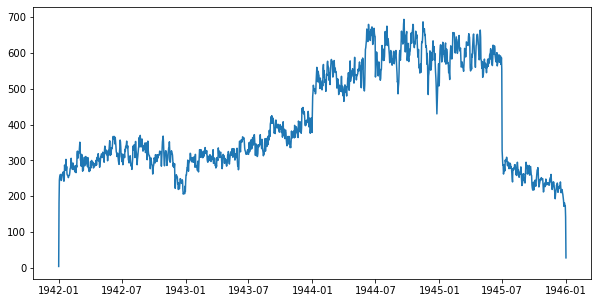

In [430]:
fig, ax = plt.subplots(1,1, figsize=(10, 5), facecolor='w', edgecolor='k')

plt.plot(obs.datetime,obs[2])

**In 1943, are there only obs 1x per day from a given ship/ID?**

sort by id, then by doy and count - subset for only class - 22 (DD)

In [447]:
year = 1946
for sid in dfg.get_group(year).groupby('ID_clean').groups:
    dfid = (dfg.get_group(year).groupby('ID_clean')).get_group(sid)
    #print(sid,dfid.groupby(dfid.index.dayofyear).count()['time'])


In [448]:
(dfg.get_group(year).groupby('ID_clean')).count().to_csv(str(year)+'_stats.csv')

In [449]:
(df_m.groupby('ID_clean')).count().to_csv('All_stats.csv')

In [450]:
df_m.to_csv('Deck195_CleanID.csv')

In [452]:
df_m.dropna(subset=['SST'])

,time,latitude,longitude,ID,AT,SLP,DCK,SID,PT,UID,W,D,SST,QI10,ID_clean,ID_pre,ID_suf
time,,,,,,,,,,,,,,,,,
1941-12-31 23:00:00+00:00,1941-12-31T23:00:00Z,-9.5,135.5,12211,27.8,1009.8,195,1.0,0.0,0M8E1B,9.8,20,30.0,NaN,12211,12,211
1942-01-01 00:00:00+00:00,1942-01-01T00:00:00Z,-6.5,113.5,12230,27.8,1007.8,195,1.0,0.0,0M8E2Q,7.2,270,30.0,NaN,12230,12,230
1942-01-01 00:00:00+00:00,1942-01-01T00:00:00Z,-9.5,116.5,06047,28.3,1006.1,195,1.0,0.0,0M8E2R,6.7,290,28.9,NaN,06047,06,047
1942-01-01 00:00:00+00:00,1942-01-01T00:00:00Z,-11.5,127.5,06012,27.8,1007.5,195,1.0,0.0,0M8E2T,4.1,270,30.6,NaN,06012,06,012
1942-01-01 02:00:00+00:00,1942-01-01T02:00:00Z,-16.5,145.5,02024,27.2,1012.2,195,1.0,0.0,0M8E40,2.6,90,28.3,NaN,02024,02,024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946-01-01 05:00:00+00:00,1946-01-01T05:00:00Z,31.5,223.5,62020.0,18.3,1021.7,195,1.0,0.0,0NBVWE,4.6,200,18.9,NaN,62020,62,020
1946-01-01 05:00:00+00:00,1946-01-01T05:00:00Z,26.5,220.5,52106.0,21.1,NaN,195,1.0,0.0,0NBVWN,8.2,90,21.1,NaN,52106,52,106
1946-01-01 06:00:00+00:00,1946-01-01T06:00:00Z,21.5,215.5,28018.0,22.2,1014.9,195,1.0,0.0,0NBVYI,11.8,110,22.8,NaN,28018,28,018


In [453]:
415874/596379

0.6973317303258498